In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
train_data_path = r"/Users/pranavi/Downloads/Data Science/tomato/train"

In [3]:
test_data_path = r"/Users/pranavi/Downloads/Data Science/tomato/val"

In [4]:
img_size = 120

In [5]:
img_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

In [6]:
train_data = ImageFolder(train_data_path,transform=img_transform)

In [7]:
test_data = ImageFolder(test_data_path, transform= img_transform)

In [8]:
len(train_data)

10000

In [9]:
len(test_data)

1000

In [10]:
train_data.class_to_idx

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [11]:
train_data, val_data = random_split(train_data, [9900,100])

In [13]:
train_loader = DataLoader(train_data, batch_size=64, shuffle = True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [14]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 120, 120]) torch.Size([64])


In [15]:
def show_img_batch(data):
    for images, labels in data:
        plt.figure(figsize=(20,10))
        plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


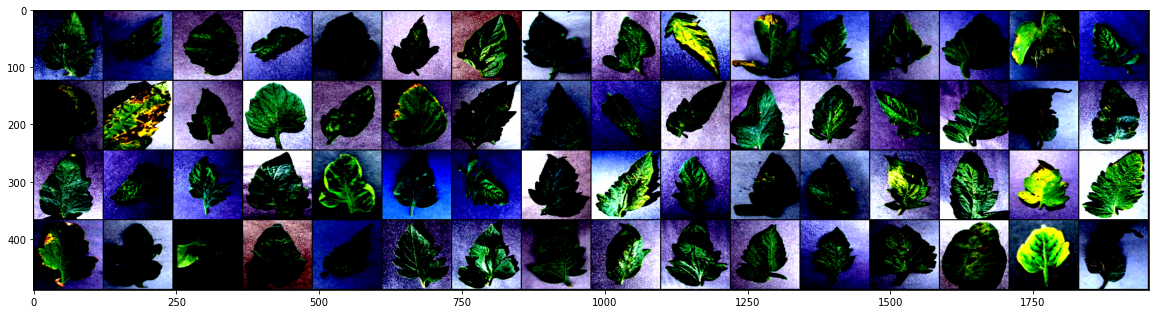

In [16]:
show_img_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


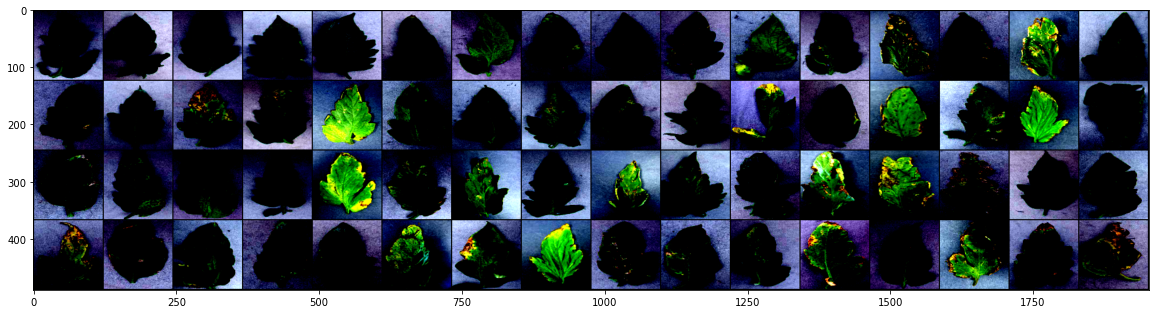

In [17]:
show_img_batch(test_loader)

In [18]:
class CNN(nn.Module):
    def __init__(self, kernel_size=3, out_channels1=16, out_channels2=32, out_channels3=64):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
                        nn.Conv2d(in_channels=3, out_channels=out_channels1, kernel_size=kernel_size), #120-2=118
                        nn.ReLU(),
                        nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=kernel_size),#116
                        nn.ReLU(),
                        nn.MaxPool2d(2), #58
                        nn.Conv2d(in_channels=out_channels2, out_channels=out_channels3, kernel_size=kernel_size),#56
                        nn.ReLU(),
                        nn.MaxPool2d(2)) #28
        
        self.classifier = nn.Sequential(
                            nn.Linear(28*28*64, 256),
                            nn.ReLU(),
                            nn.Linear(256,86),
                            nn.ReLU(),
                            nn.Linear(86,10))
    
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1, 28*28*64)
        x = self.classifier(x)
        
        return x

In [19]:
model = CNN()
print(model.parameters)

<bound method Module.parameters of CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=86, bias=True)
    (3): ReLU()
    (4): Linear(in_features=86, out_features=10, bias=True)
  )
)>


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
def CNN_train(loss_fn, optimizer):
    
    epochs = 5
    
    training_acc = []
    training_loss = []
    testing_acc = []
    testing_loss = []
    
    for epoch in range(epochs):
        
        train_acc = 0.0
        train_loss = 0.0
        
        model.eval()
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(output,1)
            
            train_acc += (predictions == labels).sum().item()
            train_loss += loss.item()
            
        training_acc.append(train_acc/len(train_data))
        training_loss.append(train_loss/len(train_loader))
        
        model.eval()
        
        test_acc = 0.0
        test_loss = 0.0
        
        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images)
                loss = loss_fn(output, labels)
                
                predictions = torch.argmax(output,1)
                
                test_acc += (predictions == labels).sum().item()
                test_loss += loss.item()
            
            testing_acc.append(test_acc/len(test_data))
            testing_loss.append(test_loss/len(test_loader))
        
        print("Epochs:{},Training Accuracy:{:.2f},Training Loss:{:.2f},Testing Accuracy:{:.2f},Testing Loss:{:.2f}".format(
        epoch+1, train_acc/len(train_data), train_loss/len(train_loader), test_acc/len(test_data),
        test_loss/len(test_loader)))
        
    plt.title("Accuracy Vs Epochs")
    plt.plot(range(epochs), training_acc, label="Training Accuracy")
    plt.plot(range(epochs), testing_acc, label = "Testing Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    plt.title("Loss Vs Epochs")
    plt.plot(range(epochs), training_loss, label="Training Loss")
    plt.plot(range(epochs), testing_loss, label = "Testing Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
            

Epochs:1,Training Accuracy:0.61,Training Loss:1.12,Testing Accuracy:0.75,Testing Loss:0.74
Epochs:2,Training Accuracy:0.84,Training Loss:0.46,Testing Accuracy:0.84,Testing Loss:0.45
Epochs:3,Training Accuracy:0.89,Training Loss:0.32,Testing Accuracy:0.87,Testing Loss:0.39
Epochs:4,Training Accuracy:0.92,Training Loss:0.22,Testing Accuracy:0.89,Testing Loss:0.37
Epochs:5,Training Accuracy:0.94,Training Loss:0.18,Testing Accuracy:0.87,Testing Loss:0.42


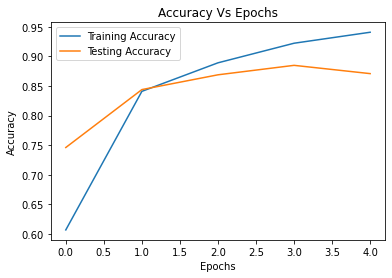

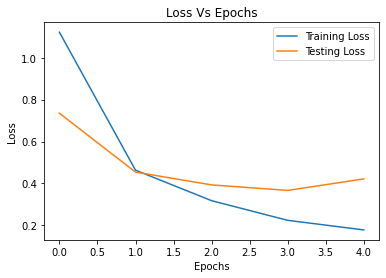

In [22]:
CNN_train(loss_fn, optimizer)

In [32]:
def predict_img(img, model):
    x = img.unsqueeze(0)
    y = model(x)
    
    prediction = torch.argmax(y,dim=1)
    return test_data.classes[prediction]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label Tomato___Bacterial_spot Predicted Label Tomato___Bacterial_spot


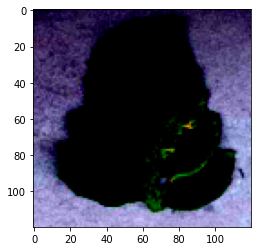

In [33]:
img, label = test_data[11]
plt.imshow(img.permute(1,2,0))
print("Actual Label", test_data.classes[label], "Predicted Label", predict_img(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label Tomato___Early_blight Predicted Label Tomato___Early_blight


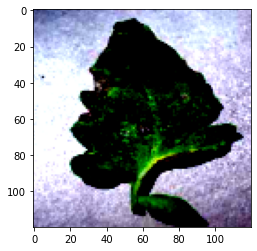

In [34]:
img, label = test_data[121]
plt.imshow(img.permute(1,2,0))
print("Actual Label", test_data.classes[label], "Predicted Label", predict_img(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label Tomato___Tomato_mosaic_virus Predicted Label Tomato___Tomato_mosaic_virus


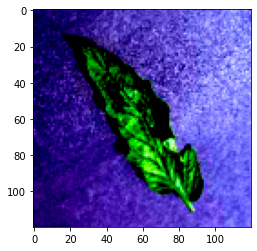

In [35]:
img, label = test_data[898]
plt.imshow(img.permute(1,2,0))
print("Actual Label", test_data.classes[label], "Predicted Label", predict_img(img,model))